In [ ]:
random_seed=7
from numpy.random import seed
seed(random_seed)
# from tensorflow import set_random_seed
# set_random_seed(random_seed)
import numpy as np

In [ ]:
import tensorflow as tp
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import pandas as pd
from keras import backend as K
import math
import matplotlib.pyplot as plt
import os
from tensorflow.keras import regularizers 
import statsmodels.api as sm  
# from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
global varss # defining all global variables here.
global count

In [ ]:
#checking if GPU is used 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1796795098191799302
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11662913454729075551
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
def mean_imputation(dataset): 
    """"""
    imputed_dataset=dataset.fillna(dataset.mean())
    return imputed_dataset

In [ ]:
#split into input (X) and output (Y)
def splitXY(dataset): 
    """
    Takes numpy array as input and converts first column into Y and rest into X
    """
    m,n=dataset.shape
    Y=dataset[:,n-1]
    X=dataset[:,0:n-1]
    return X,Y

#X,Y= splitXY(dataset_np_array)

In [ ]:
def r_squared(y_true, y_pred):
    
    sse=tp.reduce_sum(tp.square(tp.subtract(y_pred,y_true)))
    #using sst as y_true-y_mean 's squared mean
    y_mean= tp.reduce_mean(y_true)
    sst=tp.reduce_sum(tp.square(tp.subtract(y_true,y_mean)))
    r_square=tp.subtract(float(1),tp.divide(sse,sst))
    
    """
    m=tp.to_float(tp.size(y_true))
    y_true_sum_sq=(tp.square(tp.reduce_sum(y_true)))
    y_sq_mean=tp.divide(y_true_sum_sq,m)
    sst=tp.subtract(tp.tensordot(y_true,y_true,0),m*tp.square(tp.reduce_mean(y_true)))
    r_square=tp.subtract(float(1),tp.divide(sse,sst))
    """
    return r_square

In [ ]:
def adj_r_squared(y_true, y_pred):
    sse=tp.reduce_sum(tp.square(tp.subtract(y_pred,y_true)))
    #using sst as y_true-y_mean 's squared mean
    y_mean= tp.reduce_mean(y_true)
    sst=tp.reduce_sum(tp.square(tp.subtract(y_true,y_mean)))
    r_square=tp.subtract(float(1),tp.divide(sse,sst))
    
    #n=model.count_params()#this part was working before but now is not..how to get model here though?
    #n=sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    n = tp.constant(count, dtype=tp.float32)
    #n=tp.to_float(count)
    #m=tp.to_float(tp.size(y_true))
    rdf=tp.divide(tp.subtract(tp.constant(instances, dtype=tp.float32),float(1)),tp.subtract(tp.constant(instances, dtype=tp.float32),n))
    r_adj_square=tp.subtract(float(1),tp.tensordot(rdf,tp.subtract(float(1),r_square),0))
    return r_adj_square

In [ ]:
def perceptronModel(X_dim=7,optimizer_name="adam"):
    """Takes number of X features and activation name as input and outputs a keras model for perceptron"""
    model = Sequential()
    model.add(Dense(1, input_dim=X_dim,activation="linear",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer='zeros'))
    #model.add(Dense(1,activation='linear',kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer=keras.initializers.RandomNormal(stddev=1)))
    #model.add(Dense(1,kernel_initializer='normal'))
    global count
    count=model.count_params()
    #model.add(Dense(1, input_dim=X_dim, activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer=keras.initializers.RandomNormal(stddev=1)))
    # Compile model
    sgd=optimizers.SGD(lr=0.05, momentum=0.05, decay=0.0, nesterov=False)
    rmsprop=keras.optimizers.RMSprop(lr=0.05, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error',optimizer=optimizer_name,metrics=['mse',r_squared,adj_r_squared])
    
    return model

In [ ]:
def neuralNetwork3LModel(X_dim,activation_name='relu',optimizer_name="adam"):
    """Takes number of X features and activation name as input and outputs a keras model for perceptron"""
    model = Sequential()
    model.add(Dense(7, input_dim=X_dim,activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_initializer='zeros'))
    model.add(Dense(1,activation='linear',kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer='zeros'))
    #model.add(Dense(1,kernel_initializer='normal'))
    
    #model.add(Dense(1, input_dim=X_dim, activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer=keras.initializers.RandomNormal(stddev=1)))
    # Compile model
    global count
    count=model.count_params()#-X_dim+1
    sgd=optimizers.SGD(lr=0.05, momentum=0.1, decay=0.0, nesterov=False)
    rmsprop=keras.optimizers.RMSprop(lr=0.05, rho=0.1, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error',optimizer=optimizer_name,metrics=['mse',r_squared,adj_r_squared])

    
    return model

In [ ]:
def neuralNetwork5LModel(X_dim,activation_name='relu',optimizer_name="adam"):
    """Takes number of X features and activation name as input and outputs a keras model for perceptron"""
    model = Sequential()
    model.add(Dense(5, input_dim=X_dim,activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer='zeros'))
    model.add(Dense(5,activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_initializer='zeros'))
    model.add(Dense(5,activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_initializer='zeros'))
    model.add(Dense(1,activation='linear',kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer='zeros'))
    #model.add(Dense(1,kernel_initializer='normal'))
    
    #model.add(Dense(1, input_dim=X_dim, activation=activation_name,kernel_initializer=keras.initializers.RandomNormal(stddev=1),bias_initializer=keras.initializers.RandomNormal(stddev=1)))
    # Compile model
    count=model.count_params() #-3*X_dim +1
    print('Count of parameters :'+str(count))
    sgd=optimizers.SGD(lr=0.05, momentum=0.05, decay=0.0, nesterov=False)
    model.compile(loss='mean_squared_error',optimizer=optimizer_name,metrics=['mse',r_squared,adj_r_squared])

    
    return model

In [ ]:
def fit_model(X,Y,name='NeuralNetwork3L',activation_name="relu",optimizer_name="adam"):
    if(len(X.shape))==1: 
        X_size=X.shape
        X_dim=1
    else :    
        (X_size,X_dim)=X.shape
    global instances
    instances=X_size
    if(name=='Perceptron'):
        model =perceptronModel(X_dim,optimizer_name)
    elif(name=='NeuralNetwork3L'):
        print("iam here")
        model =neuralNetwork3LModel(X_dim,activation_name,optimizer_name)
    elif(name=='NeuralNetwork5L'):
        model =neuralNetwork5LModel(X_dim,activation_name,optimizer_name)
    else: 
        raise Exception("Model Name is not correct: Please choose between given models")
    
    count=model.count_params() #-3*X_dim +1
    print('Count of parameters :'+str(count))
    model.summary()
    #early stopping 
    es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=10)
    # Fit the model
    with tp.device('/device:CPU:0'):
        print("iam here")
        model.fit(X, Y, epochs=1000, batch_size=16,callbacks=[es])
        
    return model
#model=fit_model(X,Y)

In [ ]:
def eval_model(X,Y,model):
#model evaluation.

    scores = model.evaluate(X, Y, verbose=0)
        
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]))
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    return scores
#eval_model(X,Y,model)

In [ ]:
#To find RCV value
def cross_val_split(dataset):
    #dataset is split into 80:20 ratio of train and test
    np.random.shuffle(dataset)
    m,n=dataset_np_array.shape
    count=math.ceil(m*0.8)
    training, test = dataset[:count,:], dataset[count:,:]
    X_train,Y_train=splitXY(training)
    X_test,Y_test=splitXY(test)
#     model=fit_model(X_train,Y_train)
#     # evaluate the model
#     scores = eval_model(X_test,Y_test,model)
#     r_square_cv=dict_scores[model.metrics_names[2]]=scores[2]
    return X_train,Y_train,X_test,Y_test   
#cross_val_split(dataset_np_array)

In [ ]:
def forward_selection(dataset,modelname="Perceptron",activation_name="relu",optimizer_name="adam"): 
    X,Y=splitXY(dataset)
    X_train,Y_train,X_test,Y_test=cross_val_split(dataset)    
    m,n=X.shape
    X_cols = [] # buffer list that tells which column index is in X right now...
    X_cols_cv=[]
    X_set=np.empty((m,0))#for test and train with cv..this would need to be different..
    #need to save the below values for all models calculated in for loop and only save the best sse's
    
    m_train,n_train=X_train.shape
    m_test,n_test=X_test.shape
    X_train_set=np.empty((m_train,0))
    X_test_set=np.empty((m_test,0))
    
    r_square=[]
    r_adj=[]
    r_square_cv=[]
    r_adj_cv=[]
    
    while(len(X_cols)<n):
        sse=[]
        sse_cv=[]
        r_square_best=[]
        r_adj_best=[]
        r_square_cv_best=[]
        r_adj_cv_best=[]
        for i in range(0,n) :
            if i not in X_cols :
                #for rsq and radjsq
                mno,nno=X_train_set.shape
                X_train_set_copy=X_train[:,X_cols+[i]]
                model=fit_model(X_train_set_copy,Y_train,modelname,activation_name,optimizer_name)
            
                X_test_set_copy=X_test[:,X_cols+[i]]
                scores=eval_model(X_test_set_copy,Y_test,model)
                r_square_cv_best.append(scores[2])
                r_adj_cv_best.append(scores[3])
                
                scores=eval_model(X_train_set_copy,Y_train,model)
                sse.append(float(scores[1]))
                r_square_best.append(scores[2])
                r_adj_best.append(scores[3])
                
                
            else: 
                sse.append(math.inf)#to
                r_square_best.append(float('-inf'))
                r_adj_best.append(float('-inf'))                
                r_square_cv_best.append(float('-inf'))
                r_adj_cv_best.append(float('-inf'))
                
        #for rsq and radjsq
        best_index=sse.index(min(sse))
        X_cols.append(best_index)
        r_square_cv.append(r_square_cv_best[best_index])
        r_adj_cv.append(r_adj_cv_best[best_index])
        r_square.append(r_square_best[best_index])
        r_adj.append(r_adj_best[best_index])

    return r_square,r_adj,r_square_cv


In [ ]:
def backward_elimination(dataset,modelname="Perceptron",activation_name="relu",optimizer_name="adam"): 
    X,Y=splitXY(dataset)
    X_train,Y_train,X_test,Y_test=cross_val_split(dataset)    
    m,n=X.shape
    X_cols = [] # buffer list that tells which column index is in X right now...
    X_cols_cv=[]
    X_set=np.empty((m,0))#for test and train with cv..this would need to be different..
    #need to save the below values for all models calculated in for loop and only save the best sse's
    
    m_train,n_train=X_train.shape
    m_test,n_test=X_test.shape
    X_train_set=np.empty((m_train,0))
    X_test_set=np.empty((m_test,0))
    
    r_square=[]
    r_adj=[]
    r_square_cv=[]
    r_adj_cv=[]
    
    while(len(X_cols)<n):
        sse=[]
        sse_cv=[]
        r_square_best=[]
        r_adj_best=[]
        r_square_cv_best=[]
        r_adj_cv_best=[]
        for i in range(n-1,0,-1) :
            if i not in X_cols :
                #for rsq and radjsq
                mno,nno=X_train_set.shape
                X_train_set_copy=X_train[:,X_cols+[i]]
                model=fit_model(X_train_set_copy,Y_train,modelname,activation_name,optimizer_name)
            
                X_test_set_copy=X_test[:,X_cols+[i]]
                scores=eval_model(X_test_set_copy,Y_test,model)
                r_square_cv_best.append(scores[2])
                r_adj_cv_best.append(scores[3])
                
                scores=eval_model(X_train_set_copy,Y_train,model)
                sse.append(float(scores[1]))
                r_square_best.append(scores[2])
                r_adj_best.append(scores[3])
                
                
            else: 
                sse.append(math.inf)#to
                r_square_best.append(float('-inf'))
                r_adj_best.append(float('-inf'))                
                r_square_cv_best.append(float('-inf'))
                r_adj_cv_best.append(float('-inf'))
                
        #for rsq and radjsq
        best_index=sse.index(min(sse))
        X_cols.append(best_index)
        r_square_cv.append(r_square_cv_best[best_index])
        r_adj_cv.append(r_adj_cv_best[best_index])
        r_square.append(r_square_best[best_index])
        r_adj.append(r_adj_best[best_index])

    return r_square,r_adj,r_square_cv


In [ ]:
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [ ]:
def save_plots(datasetno,r_square,r_adj,r_square_cv,modelname,tech):
    m,n=dataset.shape
    print(m,n)
    print(r_square,r_adj,r_square_cv)
    t=[i+1 for i in range(len(r_square))]
    plt.plot(t,[value*100 for value in r_square], 'r--', linewidth=2.0,label="R-squared")
    plt.plot( t, [value*100 for value in r_adj], 'bs--',linewidth=2.0,label="R^2-adjusted")
    plt.plot( t,[value*100 for value in r_square_cv],'g^--',linewidth=2.0,label="Rcv-square")
    plt.xlabel(tech)
    plt.ylabel("R square values")
    plt.legend()
    x=str(datasetno)
    if not os.path.exists('../../plots/'+x):
        os.makedirs('../../plots/'+x)
    plt.savefig('../../plots/'+x+'/'+modelname+tech+'.png')
    plt.show()

In [ ]:
dataset = pd.read_csv("/content/sample_data/1.csv", delimiter=",")

In [ ]:
dataset.shape

(406, 8)

In [ ]:
dataset.loc[:, dataset.columns != 'mpg']

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,8,307.0,130.0,3504,12.0,70,1
1,8,350.0,165.0,3693,11.5,70,1
2,8,318.0,150.0,3436,11.0,70,1
3,8,304.0,150.0,3433,12.0,70,1
4,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...
401,4,140.0,86.0,2790,15.6,82,1
402,4,97.0,52.0,2130,24.6,82,2
403,4,135.0,84.0,2295,11.6,82,1
404,4,120.0,79.0,2625,18.6,82,1


In [ ]:
dataset[dataset.columns[1:] ]

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,8,307.0,130.0,3504,12.0,70,1
1,8,350.0,165.0,3693,11.5,70,1
2,8,318.0,150.0,3436,11.0,70,1
3,8,304.0,150.0,3433,12.0,70,1
4,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...
401,4,140.0,86.0,2790,15.6,82,1
402,4,97.0,52.0,2130,24.6,82,2
403,4,135.0,84.0,2295,11.6,82,1
404,4,120.0,79.0,2625,18.6,82,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Streaming output truncated to the last 5000 lines.
Epoch 344/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6722 - mse: 0.6722 - r_squared: -0.0431 - adj_r_squared: -0.1154
Epoch 345/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.6440 - mse: 0.6440 - r_squared: -0.0234 - adj_r_squared: -0.0943
Epoch 346/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.6168 - mse: 0.6168 - r_squared: -0.0509 - adj_r_squared: -0.1237
Epoch 347/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.7068 - mse: 0.7068 - r_squared: -0.1048 - adj_r_squared: -0.1814
Epoch 348/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6493 - mse: 0.6493 - r_squared: -0.0772 - adj_r_squared: -0.1519
Epoch 349/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.6244 - mse: 0.6244 - r_squared: -0.0249 - adj_r_squared: -0.0960
Epoch 350/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6842 - mse: 0

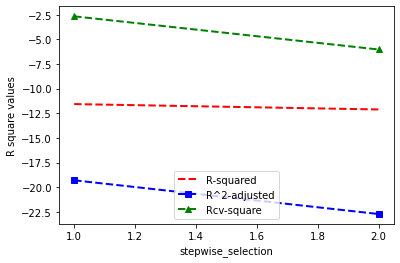

Streaming output truncated to the last 5000 lines.
21/21 [==============================] - 0s 4ms/step - loss: 0.6519 - mse: 0.6482 - r_squared: -0.0901 - adj_r_squared: -0.1932
Epoch 346/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6218 - mse: 0.6180 - r_squared: -0.0770 - adj_r_squared: -0.1788
Epoch 347/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.6149 - mse: 0.6112 - r_squared: -0.0800 - adj_r_squared: -0.1822
Epoch 348/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.6317 - mse: 0.6280 - r_squared: -0.1004 - adj_r_squared: -0.2045
Epoch 349/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6402 - mse: 0.6365 - r_squared: -0.0582 - adj_r_squared: -0.1583
Epoch 350/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6380 - mse: 0.6343 - r_squared: -0.0792 - adj_r_squared: -0.1813
Epoch 351/1000
21/21 [==============================] - 0s 3ms/step - loss: 0.6752 - mse: 0.6715 - r_squar

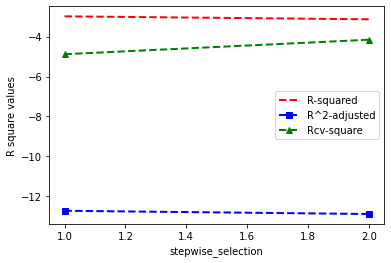

Streaming output truncated to the last 5000 lines.
Epoch 11/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.8428 - mse: 0.8422 - r_squared: -0.4542 - adj_r_squared: -0.5550
Epoch 12/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.8607 - mse: 0.8601 - r_squared: -0.5102 - adj_r_squared: -0.6148
Epoch 13/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.7878 - mse: 0.7872 - r_squared: -0.3922 - adj_r_squared: -0.4887
Epoch 14/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.7027 - mse: 0.7021 - r_squared: -0.2905 - adj_r_squared: -0.3799
Epoch 15/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.6666 - mse: 0.6660 - r_squared: -0.3474 - adj_r_squared: -0.4408
Epoch 16/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.6832 - mse: 0.6826 - r_squared: -0.3750 - adj_r_squared: -0.4702
Epoch 17/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.6355 - mse: 0.6350 -

In [ ]:
#running script
activations_exp=['sigmoid']
optimizer_exp=['adam']
modelnames=["NeuralNetwork3L","NeuralNetwork5L"]
techniques = ["stepwise_selection","forward_selection","backward_elimination"]

for activation_name in activations_exp:
    for optimizer_name in optimizer_exp:
      for tech in techniques:
            for modelname in modelnames: 
                dataset = pd.read_csv("/content/sample_data/1.csv", delimiter=",")
                dataset=mean_imputation(dataset)
                if tech is "stepwise_selection":
                  features = stepwise_selection(dataset[dataset.columns[1:]], dataset[dataset.columns[0]])
                  dataset_np_array=dataset[features].values
                  r_square,r_adj,r_square_cv = forward_selection(dataset_np_array,modelname,activation_name,optimizer_name)
                elif tech is "forward_selection":
                  dataset_np_array=dataset.values
                  r_square,r_adj,r_square_cv = forward_selection(dataset_np_array,modelname,activation_name,optimizer_name)
                else:
                  dataset_np_array=dataset.values
                  r_square,r_adj,r_square_cv = backward_elimination(dataset_np_array,modelname,activation_name,optimizer_name)
                save_plots(1,r_square,r_adj,r_square_cv,modelname,tech)

In [ ]:
#running script
activation_name='sigmoid'
optimizer_name='adam'
modelname="Perceptron"
techniques = ["stepwise_selection","forward_selection","backward_elimination"]


for tech in techniques: 
          dataset = pd.read_csv("/content/sample_data/1.csv", delimiter=",")
          dataset=mean_imputation(dataset)
          if tech is "stepwise_selection":
            features = stepwise_selection(dataset[dataset.columns[1:]], dataset[dataset.columns[0]])
            dataset_np_array=dataset[features].values
            r_square,r_adj,r_square_cv = forward_selection(dataset_np_array,modelname,activation_name,optimizer_name)
          elif tech is "forward_selection":
            dataset_np_array=dataset.values
            r_square,r_adj,r_square_cv = forward_selection(dataset_np_array,modelname,activation_name,optimizer_name)
          else:
            dataset_np_array=dataset.values
            r_square,r_adj,r_square_cv = backward_elimination(dataset_np_array,modelname,activation_name,optimizer_name)
          save_plots(1,r_square,r_adj,r_square_cv,modelname,tech)